# Power dependant CPT measurements with 2nd order of EOM.
## Power is the total Power with microwave turned off.

In [170]:
from qutip import *

import numpy as np
from numpy import pi as pi
from numpy import exp as exp
from numpy import sqrt as sqrt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.size'] = 12
from scipy.optimize import curve_fit as cf

In [171]:
c0 = 299792458

def boltzmann(gs, T):
    return np.exp(-6.26e-34*gs*1e9/(1.38e-23*T))

def bin_data(xs, ys, res):
    xs_binned = np.zeros(int(xs.size//res))
    ys_binned = np.zeros_like(xs_binned)
    
    for i in range(int(xs.size//res)-1):
        xs_binned[i] = np.mean(xs[res*i:res*i+1])
        ys_binned[i] = np.mean(ys[res*i:res*i+1])
    
    xs_binned[-1] = np.mean(xs[-int(xs.size%res):-1])
    ys_binned[-1] = np.mean(ys[-int(xs.size%res):-1])
    
    return xs_binned, ys_binned

def lorentzian(freqs, freq0, Gamma, A, m, c):
    return A* (Gamma/2)**2/((freqs-freq0)**2 + (Gamma/2)**2) + m*freqs + c

def triple_lorentzian(freqs, freq0, Gamma0, A0, freq1, Gamma1, A1, freq2, Gamma2, A2, m, c):
    spectrum = lorentzian(freqs, freq0, Gamma0, A0, m/3, c/3)
    spectrum += lorentzian(freqs, freq1, Gamma1, A1, m/3, c/3)
    spectrum += lorentzian(freqs, freq2, Gamma2, A2, m/3, c/3)
    return spectrum

def get_rounded_xticks(ax, diviser):    
    xlims = ax.get_xlim()
    return np.arange(diviser*(xlims[0]//diviser+1), (diviser)*(xlims[1]//diviser), diviser)

def get_rounded_yticks(ax, diviser):    
    ylims = ax.get_ylim()
    return np.arange(diviser*(ylims[0]//diviser), (diviser)*(ylims[1]//diviser+1), diviser)

In [114]:
full_CPT_file = {"20221202-1244-55_ODMR_data_ch0.dat": 840}
power_dep_files = {
    '20221202-1407-20_ODMR_data_ch0': 520,
    '20221202-1408-04_ODMR_data_ch0': 400,
    '20221202-1408-58_ODMR_data_ch0': 300,
    '20221202-1409-58_ODMR_data_ch0': 214,
    '20221202-1410-55_ODMR_data_ch0': 174,
    '20221202-1414-26_ODMR_data_ch0': 140,
    '20221202-1420-39_ODMR_data_ch0': 117
}

In [115]:
cmap = mpl.cm.get_cmap("viridis", len(power_dep_files))
kwargs_data = {
    'ls':'', 
    'marker':'o', 
    'markerfacecolor':'#fff',
    'markersize':5
#     'alpha':.5
}
kwargs_fit = {
    'linestyle':'-', 
    'linewidth':2,
    'alpha':.5
}
kwargs_fills = {
    'linestyle': '--',
    'linewidth': 2,
    'edgecolor': '#666',
    'alpha':.3
}

C:\Users\Marco\AppData\Local\Temp\ipykernel_1220\4084534908.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels([ytick*1e-6 for ytick in axs[2].get_yticks()])


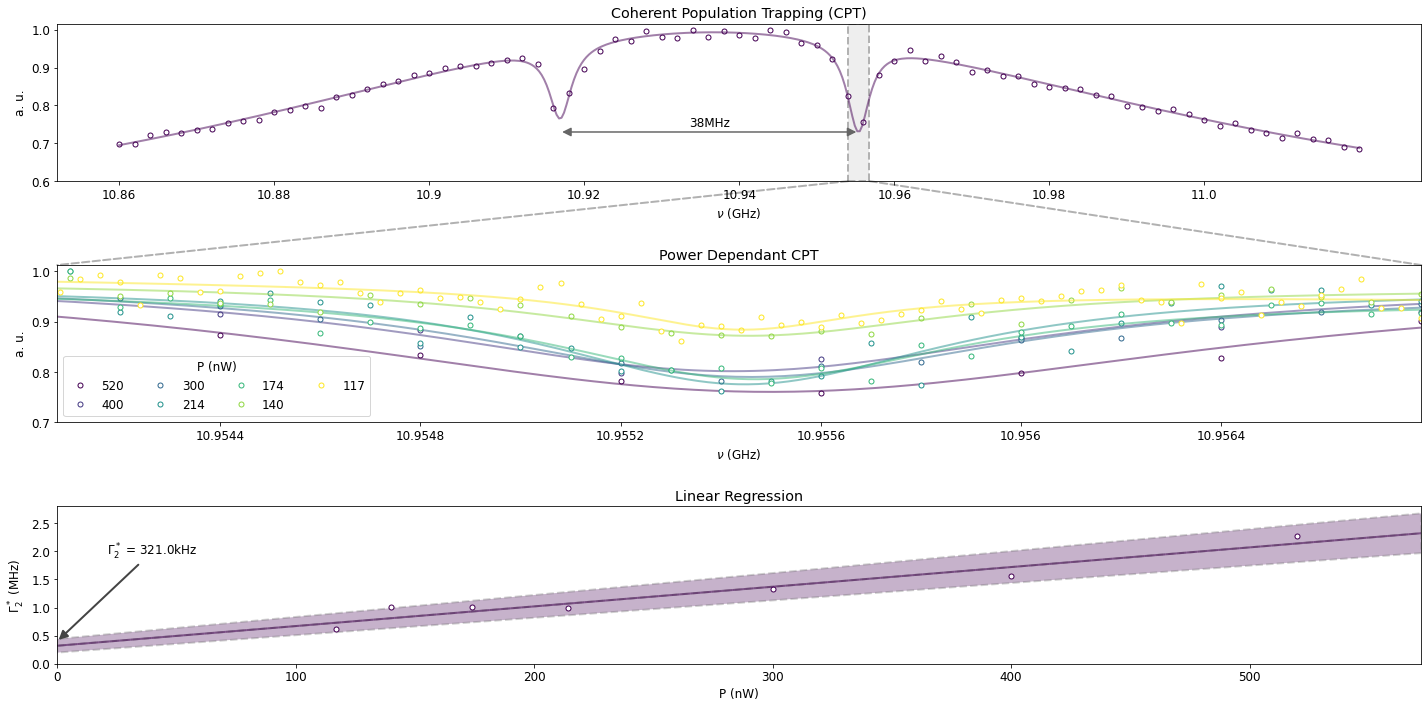

In [169]:
fig, axs = plt.subplots(3,1);

# ------------------------------ Full range CPT data ------------------------------
data = np.genfromtxt(list(full_CPT_file.keys())[0])
freqs, cts = data[:, 0], data[:, 1]
freqs *= 2
cts /= np.amax(cts)

p0 = (freqs[np.argmax(cts)]-10e6, 200e6, 1, 
      freqs[np.argmax(cts)]-30e6, 1e6, -.3, 
      freqs[np.argmax(cts)]+10e6, 1e6, -.3, 
      0*(cts[-1] - cts[0])/(freqs[-1] - freqs[0]), 0)
popt, pcov = cf(triple_lorentzian, freqs, cts, p0=p0)
p_err = sqrt(np.diag(pcov))
freq0, Gamma0, A0, freq1, Gamma1, A1, freq2, Gamma2, A2, m, c = popt

axs[0].plot(freqs, cts, color=cmap(0), **kwargs_data)
x_fit = np.linspace(np.amin(freqs), np.amax(freqs), 500)
axs[0].plot(x_fit, triple_lorentzian(x_fit, *popt), color=cmap(0), **kwargs_fit)
axs[0].annotate(
    text='',
    xy=(freq1, triple_lorentzian(freq2, *popt)),
    xytext=(freq2, triple_lorentzian(freq2, *popt)),
    arrowprops=dict(arrowstyle='<|-|>, head_width=.3, head_length=.6', 
                    color='#666', alpha=1, linewidth=1.5)
)
axs[0].annotate(
    str(round(abs(freq1- freq2)*1e-6))+"MHz",
    xy=((freq1 + (freq2-freq1)/2),triple_lorentzian(freq2, *popt)*1.02),
    ha='center', color='#000'
)
axs[0].set_xlabel(r"$\nu$ (GHz)")
axs[0].set_ylabel("a. u.")
axs[0].set_title("Coherent Population Trapping (CPT)")
axs[0].set_xticks(get_rounded_xticks(axs[0], 20e6))
axs[0].set_xticklabels([round(tick*1e-9,2) for tick in axs[0].get_xticks()])
axs[0].set_yticks(get_rounded_yticks(axs[0], 0.1))

# ------------------------------ Power dependant CPT data ------------------------------
# Dropped two measurements to get a clear linear "low" power behaviour. Following files are dropped:
#     '20221202-1434-08_ODMR_data_ch0': 1412,
#     '20221202-1432-20_ODMR_data_ch0': 835,
Powers = np.array(list(power_dep_files.values()))
Gammas = np.zeros(len(power_dep_files))
for i, (file, power) in enumerate(power_dep_files.items()):
    data = np.genfromtxt(file+".dat")
    freqs, cts = data[:, 0], data[:, 1]
    freqs *= 2
    cts /= np.amax(cts)
    axs[1].plot(freqs, cts, color=cmap(i), label=str(power), **kwargs_data)
    
    p0 = (freqs[np.argmin(cts)], 1e6, -0.1*np.amax(cts), (cts[-1] - cts[0])/(freqs[-1] - freqs[0]), np.amax(cts))
    popt, pcov = cf(lorentzian, freqs, cts, p0=p0)
    Gammas[i] = popt[1]
    x_fit = np.linspace(np.amin(freqs), np.amax(freqs), 500)
    axs[1].plot(x_fit, lorentzian(x_fit, *popt), color=cmap(i), **kwargs_fit)

axs[1].set_xlabel(r"$\nu$ (GHz)")
axs[1].set_ylabel("a. u.")
axs[1].set_title("Power Dependant CPT")
axs[1].legend(ncol=4, title='P (nW)')

xlims = (popt[0] - min(popt[0]-freqs[0], freqs[-1]-popt[0]), popt[0] + min(popt[0]-freqs[0], freqs[-1]-popt[0]))
axs[1].set_xlim(xlims)
axs[1].set_xticks(get_rounded_xticks(axs[1], 400e3))
axs[1].set_xticklabels([round(tick*1e-9,4) for tick in axs[1].get_xticks()])
axs[1].set_yticks(get_rounded_yticks(axs[1], 0.1))

# ------------------------------ Make box to indicate close-up measurements ------------------------------
axs[0].add_patch(
    plt.Rectangle(
        (axs[1].get_xlim()[0], axs[0].get_ylim()[0]), np.diff(axs[1].get_xlim()), np.diff(axs[0].get_ylim()), 
        ls='--', lw=2, ec='#b2b2b2', fc='#eee',
        transform=axs[0].transData
    )
)
con1 = ConnectionPatch(xyA=(axs[1].get_xlim()[0], axs[0].get_ylim()[0]), xyB=(axs[1].get_xlim()[0], axs[1].get_ylim()[1]), 
                          coordsA=axs[0].transData, coordsB=axs[1].transData,
                          axesA=axs[0], axesB=axs[1], ls='--', lw=2, color="#000", alpha=.3)
con2 = ConnectionPatch(xyA=(axs[1].get_xlim()[1], axs[0].get_ylim()[0]), xyB=(axs[1].get_xlim()[1], axs[1].get_ylim()[1]), 
                          coordsA=axs[0].transData, coordsB=axs[1].transData,
                          axesA=axs[0], axesB=axs[1], ls='--', lw=2, color="#000", alpha=.3)
axs[1].add_artist(con1)
axs[1].add_artist(con2)

# ------------------------------ Make linear fit to linewidths ------------------------------
axs[2].plot(Powers, np.abs(Gammas), color=cmap(0), label=str(power), **kwargs_data)

lin_fit = lambda Omega, a, c: a*Omega + c
sqrt_fit = lambda P, a, c: a*sqrt(P) + c

fit_func = lin_fit
popt, pcov = cf(fit_func, Powers, np.abs(Gammas), bounds=[(100, 100e3), (1e7, 1e6)])
p_err = np.sqrt(np.diag(pcov))

x_fit = np.linspace(0, 1.1*np.amax(Powers))
axs[2].plot(x_fit, fit_func(x_fit, *popt), color=cmap(0), **kwargs_fit)
axs[2].fill_between(x_fit, fit_func(x_fit, *(popt+p_err)), fit_func(x_fit, *popt), color=cmap(0), **kwargs_fills)
axs[2].fill_between(x_fit, fit_func(x_fit, *(popt-p_err)), fit_func(x_fit, *popt), color=cmap(0), **kwargs_fills)

axs[2].set_xlabel("P (nW)")
axs[2].set_ylabel("$\Gamma_2^*$ (MHz)")
axs[2].set_title("Linear Regression");

axs[2].set_xlim([0, 1.1*np.amax(Powers)])
axs[2].set_ylim([0, axs[2].get_ylim()[1]])

diviser = 100
xticklims = (0, round_to(np.amax(Powers), diviser, bound='upper'))
axs[2].set_xticks(np.arange(*xticklims, diviser))
axs[2].set_xticklabels([round(tick,2) for tick in axs[2].get_xticks()])
axs[2].set_yticklabels([ytick*1e-6 for ytick in axs[2].get_yticks()])

axs[2].annotate(
                "$\Gamma_2^*$ = "+str(round(popt[1]*1e-3,0))+"kHz",                
                xy=(0, 0.4e6), 
                xytext=(40, 2e6),
                arrowprops=dict(arrowstyle='-|>, head_width=.3, head_length=.6', 
                color='#444', alpha=1, linewidth=2),
                ha='center', va='center'
)

plt.tight_layout()
plt.savefig("Power_Dependant_CPT.png")
plt.show()